In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Merge
from keras.layers import LSTM, Add, Dropout
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [3]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1676 entries, 2014-01-07 to 2018-08-09
Data columns (total 7 columns):
Open                 1676 non-null float64
High                 1676 non-null float64
Low                  1676 non-null float64
Close                1676 non-null float64
Volume (BTC)         1676 non-null float64
Volume (Currency)    1676 non-null float64
Weighted Price       1676 non-null float64
dtypes: float64(7)
memory usage: 104.8 KB


In [5]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [6]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-08-05,7011.8,7088.4,6880.1,7026.9,3309.717739,2.314772e+07,6993.865303
2018-08-06,7026.9,7159.9,6833.0,6935.7,3151.621371,2.197671e+07,6973.145449
2018-08-07,6935.7,7149.0,6659.9,6717.8,6505.467105,4.504249e+07,6923.790147
2018-08-08,6714.9,6715.0,6120.0,6275.9,9467.831781,6.052118e+07,6392.295762
2018-08-09,6276.6,6630.5,6179.1,6588.3,5728.364480,3.677490e+07,6419.790064


In [7]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [8]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

In [9]:
data_change = data.diff()
#data_change = data_change.drop(data_change.index[0])
data_change.fillna(0, inplace=True)

In [10]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [11]:
btc_trace_change = go.Scatter(x=data_change.index, y=data_change['Weighted Price'], name= 'Price Change')
py.iplot([btc_trace_change])

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

weighted_prices = data['Weighted Price'].values.reshape(-1,1)
weighted_prices = weighted_prices.astype('float32')
scaled = scaler.fit_transform(weighted_prices)

In [13]:
weighted_prices_change = data_change['Weighted Price'].values.reshape(-1,1)
weighted_prices_change = weighted_prices_change.astype('float32')
scaled_change = scaler.fit_transform(weighted_prices_change)

In [14]:
#price_diff = weighted_prices.reshape(-1)
#price_diff = np.diff(price_diff).reshape(-1, 1)
#price_diff_scaled = scaler.fit_transform(price_diff)

In [15]:
scaled

array([[ 0.0339149 ],
       [ 0.03377341],
       [ 0.03337294],
       ..., 
       [ 0.35510239],
       [ 0.32703421],
       [ 0.32848617]], dtype=float32)

In [16]:
scaled_change

array([[ 0.52203387],
       [ 0.52145088],
       [ 0.52038378],
       ..., 
       [ 0.51129442],
       [ 0.40638372],
       [ 0.52801645]], dtype=float32)

In [17]:
train_size = int(len(scaled) * 0.9)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1508 168


In [18]:
diff_train, diff_test = scaled_change[0:train_size,:], scaled_change[train_size:len(scaled_change),:]
print(len(diff_train), len(diff_test))

1508 168


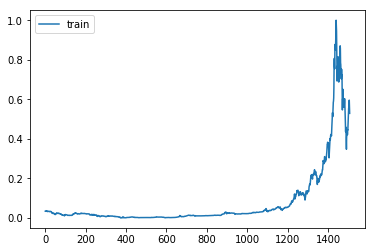

In [19]:
pyplot.plot(train, label='train')
pyplot.legend()
pyplot.show()

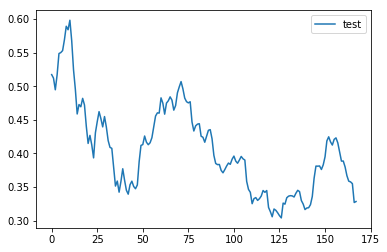

In [20]:
pyplot.plot(test, label='test')
pyplot.legend()
pyplot.show()

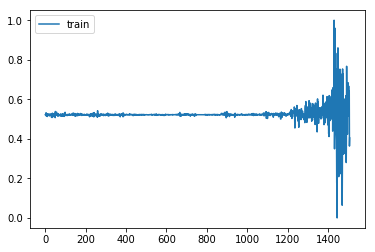

In [21]:
pyplot.plot(diff_train, label='train')
pyplot.legend()
pyplot.show()

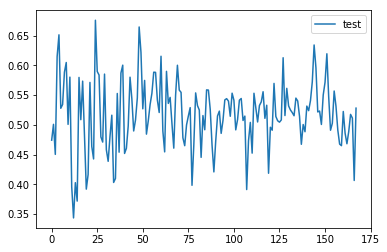

In [22]:
pyplot.plot(diff_test, label='test')
pyplot.legend()
pyplot.show()

In [23]:
def create_dataset_parts(dataset, proportion=0.7):
    train_size = int(len(scaled) * proportion)
    test_size = len(scaled) - train_size
    train, test = [], []
    sm1 = 0
    for i in range(len(dataset) - 1):
        sm1 += proportion
        a = dataset[i:(i + 1)]
        if sm1 >= 1:
            train.append(a)
            sm1-=1
        else:
            test.append(a)
    return np.array(train), np.array(test)

In [24]:
#train, test = create_dataset_parts(scaled)
#print(len(train), len(test))

In [25]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    #print(dataX.shape[0], dataY.shape[0])
    return np.array(dataX), np.array(dataY)

In [147]:
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [148]:
(trainX.shape[0], 1, trainX.shape[1])

(1498, 1, 10)

In [149]:
diff_trainX, diff_trainY = create_dataset(diff_train, look_back)
diff_testX, diff_testY = create_dataset(diff_test, look_back)

In [150]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [151]:
diff_trainX = np.reshape(diff_trainX, (diff_trainX.shape[0], 1, diff_trainX.shape[1]))
diff_testX = np.reshape(diff_testX, (diff_testX.shape[0], 1, diff_testX.shape[1]))

In [152]:
(trainX.shape[0], trainX.shape[1], trainX.shape[2])

(1498, 1, 10)

In [153]:
m_trainX = np.concatenate((trainX, diff_trainX), axis=1)
#m_trainX = trainX 
m_trainX.shape

(1498, 2, 10)

In [154]:
m_testX = np.concatenate((testX, diff_testX), axis=1)
#m_testX = testX
m_testX.shape

(158, 2, 10)

In [155]:
from sklearn.cluster import KMeans


In [156]:
xx = [1, 4, 7, 4, 9]
xx = np.array(xx)
xx = xx.reshape(-1, 1)
km = KMeans(n_clusters=2)
res = km.fit(xx)

print(km.cluster_centers_)

[[ 8.]
 [ 3.]]


In [157]:
km_input = trainX.reshape((trainX.shape[0], trainX.shape[1] * trainX.shape[2]))
#km_input = diff_trainX.reshape((diff_trainX.shape[0], diff_trainX.shape[1] * diff_trainX.shape[2]))

In [158]:
km_input = km_input[::look_back,:]

In [159]:
km_input.shape

(150, 10)

In [162]:
km = KMeans(n_clusters=50)
res = km.fit(km_input)

clusters = km.cluster_centers_

print(clusters)

[[ 0.0278823   0.02810317  0.02802709  0.02825155  0.02850197  0.02850943
   0.02788902  0.02773049  0.02703977  0.02784526]
 [ 0.56587189  0.58508605  0.60310149  0.58409894  0.53657877  0.51375192
   0.47727987  0.43615049  0.45948213  0.43436578]
 [ 0.22819315  0.23112038  0.23659322  0.24371693  0.23815094  0.23301104
   0.22101982  0.21874797  0.23313054  0.234478  ]
 [ 0.81494945  0.74943882  0.7633177   0.6872794   0.69837707  0.71182513
   0.73636401  0.78675407  0.77857387  0.83452475]
 [ 0.08601678  0.08142754  0.0789314   0.08379318  0.08116914  0.08161946
   0.08581256  0.08875918  0.09115814  0.09462083]
 [ 0.29321349  0.30539307  0.31251094  0.32212561  0.33515388  0.35738131
   0.37211937  0.37189996  0.38293886  0.37042269]
 [ 0.00428624  0.00418933  0.00405043  0.00405093  0.00414585  0.00420247
   0.00415222  0.00425078  0.00398659  0.00394783]
 [ 1.          0.97614092  0.94495404  0.86164212  0.81899518  0.69229805
   0.76782429  0.70265985  0.72226954  0.80435622]


In [163]:
chart_list = []

for c in clusters:
    cc = np.array(c)
    
    cc = cc.reshape(len(cc))
    
    chart = go.Scatter(y=cc)
    
    chart_list += [chart]
    py.iplot([chart])

#py.iplot(chart_list)